# Comparison `2t.ERA-5`

In [1]:
import os
import json 
import subprocess
import importlib

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe

import xbitinfo as xb
import xarray as xr

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

---

In [3]:
# load data
path_to_data = 'data/multi-vars-2022-jan-aug.nc'  # change this
ds = xr.open_dataset(path_to_data)
ds = ds[['t2m']].isel(time=0)

In [4]:
ds = ds.sel({'longitude': ds.longitude[::],
                   'latitude': ds.latitude[:700]
                  })

In [5]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 700, longitude: 1440)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -84.25 -84.5 -84.75
    time       datetime64[ns] 2022-01-01T12:00:00
Data variables:
    t2m        (latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-07-10 18:29:55 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

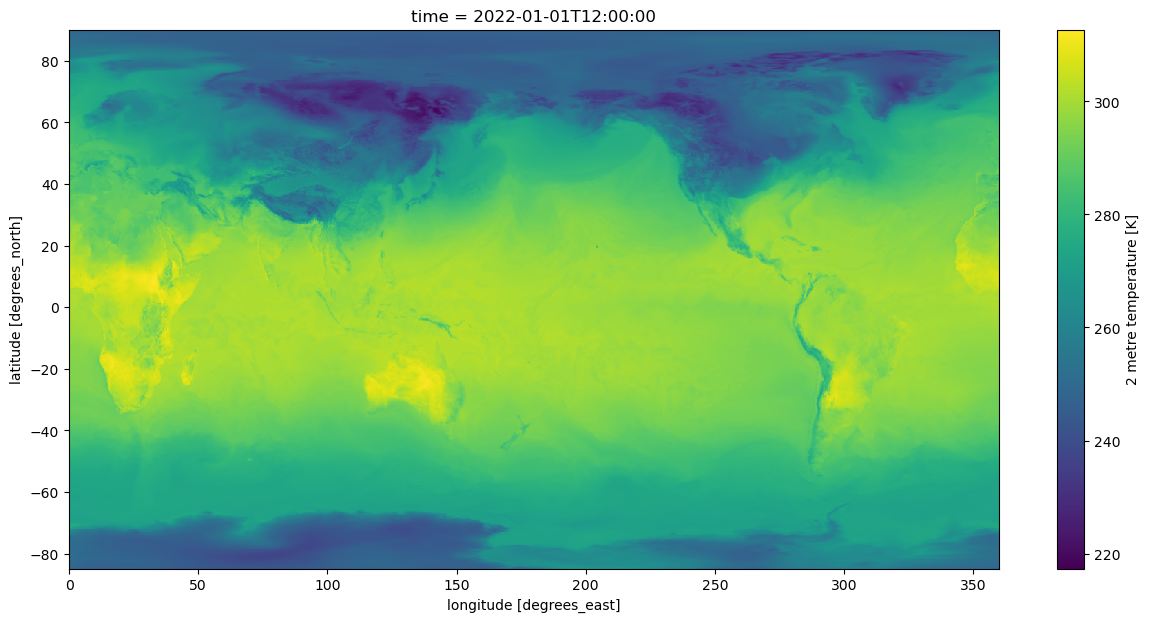

In [6]:
fig, ax = plt.subplots(figsize=(15, 7))
ds['t2m'].plot(ax=ax)

<Axes: title={'center': 'Statistical distributions'}, xlabel='value', ylabel='Probability density'>

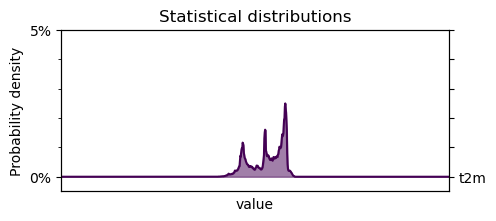

In [7]:
xb.plot_distribution(ds)

---

In [8]:
# get information content per bit
info_per_bit = xb.get_bitinformation(ds, dim="latitude", implementation="python")

  0%|          | 0/1 [00:00<?, ?it/s]

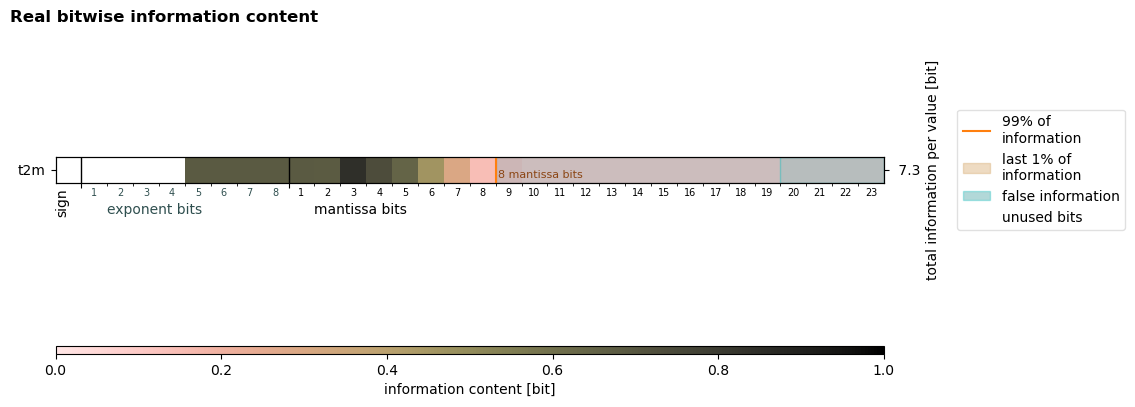

In [9]:
fig = xb.plot_bitinformation(info_per_bit)

In [10]:
# get keepbits
keepbits = xb.get_keepbits(info_per_bit, 0.99)
keepbits

<xarray.Dataset>
Dimensions:   (inflevel: 1)
Coordinates:
    dim       <U8 'latitude'
  * inflevel  (inflevel) float64 0.99
Data variables:
    t2m       (inflevel) int64 8

In [11]:
# apply bitrounding 8 kb
ds_bitrounded_99p = xb.xr_bitround(ds, keepbits)

In [12]:
# apply bitrounding 5 kb
ds_bitrounded_5 = xb.xr_bitround(ds, 5)

In [13]:
# apply bitrounding 10 kb
ds_bitrounded_10 = xb.xr_bitround(ds, 10)

---

In [14]:
ds_bitrounded_5.to_compressed_netcdf("bitrounded_compressed_5.nc")

In [15]:
ds_bitrounded_10.to_compressed_netcdf("bitrounded_compressed_10.nc")

In [16]:
ds_bitrounded_99p.to_compressed_netcdf("bitrounded_compressed_99p.nc")

In [17]:
ds.to_compressed_netcdf("compressed.nc")

In [18]:
ds.to_netcdf("original.nc")

In [19]:
!du -hs *.nc

404K	bitrounded_compressed_10.nc
68K	bitrounded_compressed_5.nc
236K	bitrounded_compressed_99p.nc
188K	compressed.nc
2.0M	original.nc


In [20]:
!rm *.nc

---

In [21]:
at_least_zero = lambda x: max(x, 0)

chunk_long, chunk_lat = [144, 70] # for int division
vrbs = ['longitude', 'latitude']
var = 'latitude'

dss = []
dss_bitrounded = []
dss_kbits = []

long_c = int(ds.longitude.size / chunk_long)
lat_c = int(ds.latitude.size / chunk_lat)


for i in range(long_c):
    for j in range(lat_c):
        temp_ds = ds.isel(longitude=slice(i*chunk_long, (i+1)*chunk_long),
                          latitude=slice(j*chunk_lat, (j+1)*chunk_lat))
        dss.append(temp_ds)
        temp_info_pbit = xb.get_bitinformation(temp_ds, dim=var, implementation="python")
        # fig = xb.plot_bitinformation(temp_info_pbit)
        temp_keepbits = xb.get_keepbits(temp_info_pbit, 0.99)
        # cope with negative keepbits
        temp_keepbits = temp_keepbits.map(at_least_zero)
        dss_kbits.append(temp_keepbits)
        temp_ds_bitrounded = xb.xr_bitround(temp_ds, temp_keepbits)
        dss_bitrounded.append(temp_ds_bitrounded)
        temp_ds_bitrounded.to_compressed_netcdf(f"bitrounded_compressed_{i}_{j}.nc")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

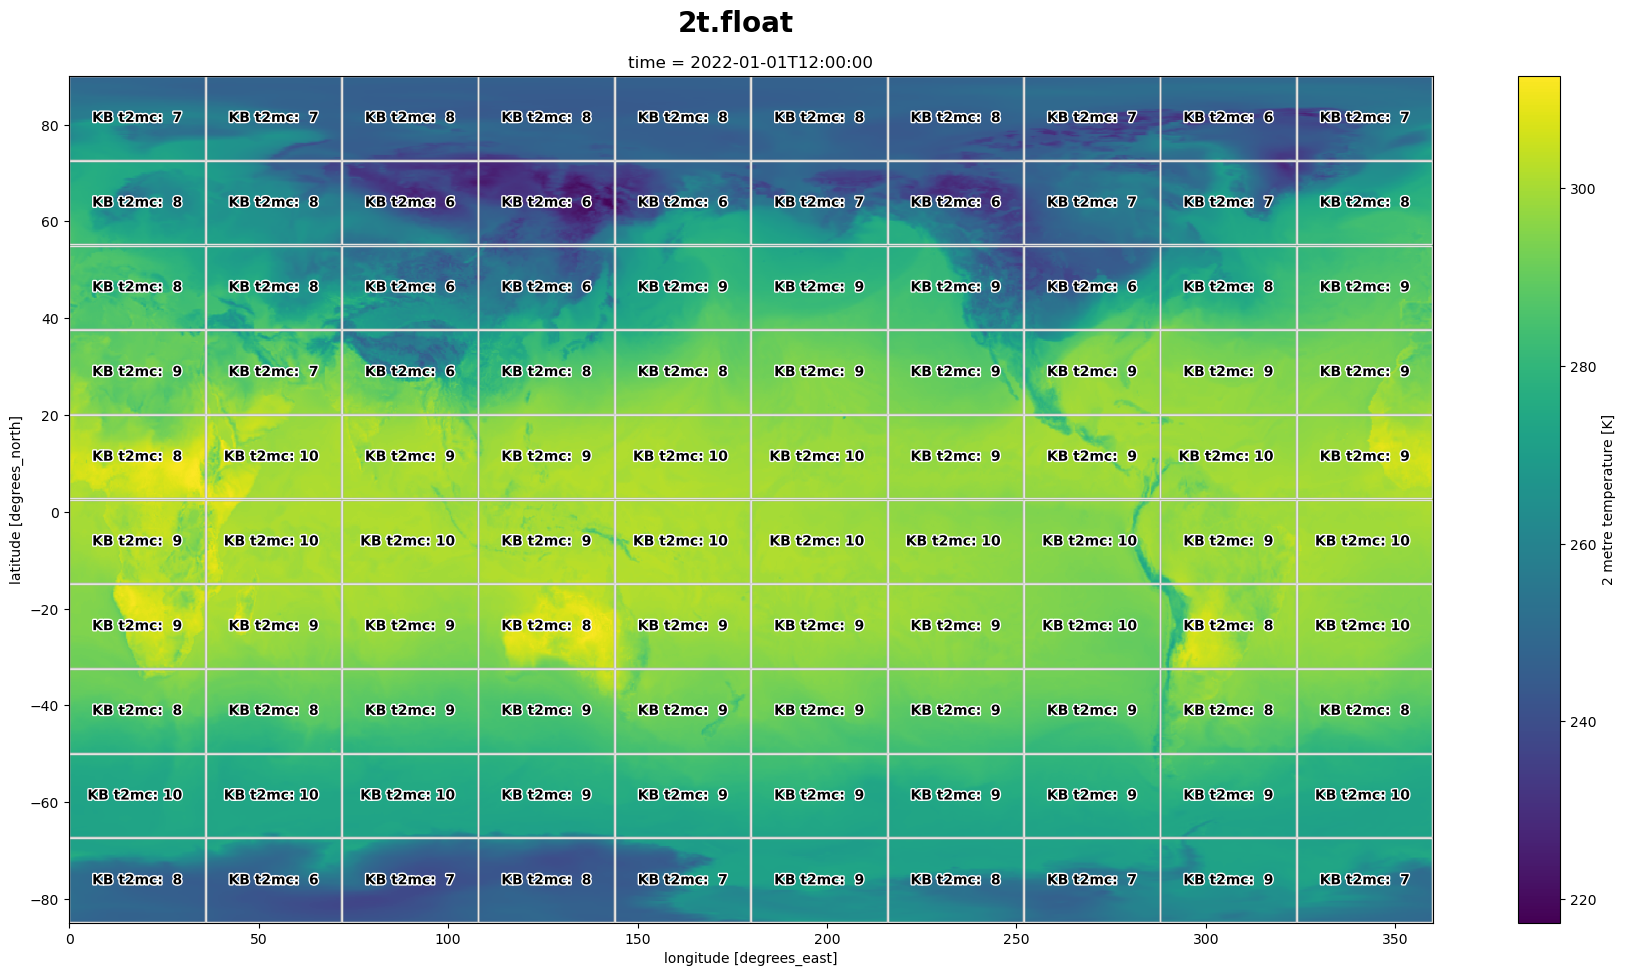

In [22]:
fig, ax = plt.subplots(figsize=(22, 11))
        
ds['t2m'].plot(ax=ax)

for i in range(len(dss_bitrounded)):
    x = float(min(dss[i].longitude[0], dss[i].longitude[-1]))
    y = float(min(dss[i].latitude[0], dss[i].latitude[-1]))
    w = float(abs(dss[i].longitude[0] - dss[i].longitude[-1]))
    h = float(abs(dss[i].latitude[0] - dss[i].latitude[-1]))
    rect = mpl.patches.Rectangle((x, y), width = w, height = h,
                                facecolor = "none", edgecolor = "#E5E4E2",
                                path_effects=[pe.withStroke(linewidth=1, foreground="gray")],
                                label='xxx')
    ax.add_patch(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()/2.0
    ax.annotate(
        f"""
        KB t2mc: {int(dss_kbits[i].t2m):2}
        """,
        (cx+12, cy), color='k', weight='bold', fontsize=10, ha='right', va='center',
        path_effects=[pe.withStroke(linewidth=2, foreground='w')]
    )
    
fig.text(.402, .92, '2t.float', weight='bold', fontsize=20)

fig.show()

In [23]:
!du -shc *.nc | grep total

1.6M	total


In [24]:
!rm *.nc